In [1]:
import pandas as pd
import numpy as np
import datatable as dt
import gc
import os, sys, glob
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
mpl.rcParams['pdf.fonttype'] = 42
sns.set_color_codes("muted")

In [112]:
# Loading
def LoadMatrixReader(filename, Chunksize, usecols, sepstr="\t"):
    file_reader = pd.read_table(filename, sep=sepstr,
                                chunksize=Chunksize, iterator=True,
                                header=None, index_col=None, usecols = usecols)
    return (file_reader)

# Read talbles No header
def LoadTables(filename, sepstr):
    dt_df = dt.fread(filename, sep=sepstr, header=True)
    df  = dt_df.to_pandas()
    del dt_df
    return(df)

# Binsize
def Binsize(binsize, p_array):
    p_array = np.divide(p_array, binsize).astype("int")*binsize
    return(p_array)

# Remove the fragments with the same bins
def Deduplicate(df, binsize):
    df.loc[:, "posbin"] = Binsize(binsize, (df["start"].values + df["end"].values)/2 )
    # fragmetn bin相同的时候， 选择长度最大的fragment
    Dedup_df = df.groupby(["read_name","posbin"], as_index=False).first()
    Dedup_df = Dedup_df.reset_index()
    return(Dedup_df)

# Find Loop anchors
def FindAnchors(df, bin_DF):
    df.loc[:, "matchID"] = df.loc[:, "chrom"].str.cat( df.posbin.astype("str"), sep="_")
    matchP = df.matchID.isin( bin_DF.index.to_list()  ) 
    df.loc[:, "anchorID"] = "NaN"
    df.loc[matchP, "anchorID"] = bin_DF.loc[ df.loc[matchP, "matchID"].to_list() ].values
    return(df)

# Filter reads not in chr1:chrX
def Filterdf(df):
    chrlist = ["chr%d"%i for i in range(1,22+1)]
    chrlist.append("chrX")
    df = df.loc[df.chrom.isin(chrlist), :]
    return(df)

# Read Match Loops
def ReadMatchLoops(df, binsize, spannum=1):
    read_dict = {
        "chrom":[],
        "read_name":[],         
        "Fragnum":[],
        "Findloops":[],
        "LoopIDs":[] }
    for (chrom, read_name), readDF in df.groupby(["chrom","read_name"]):
        Fragnum = len(readDF)
        if Fragnum < 2: # 1 fragment reads not calculate
            continue
        gregionDF = regionDF_dict[chrom]
        Findloops, LoopIDs = 0, ""
        #matchIDs = readDF.matchID.to_list()
        posmatchIDs = readDF.posbin.to_list()
        # matchIDs in left and right anchords
        #matchP = ( gregionDF.pos1binID.isin(matchIDs) ) & ( gregionDF.pos2binID.isin(matchIDs) )
        # 左右偏移 n 个 binsize 都是loop， 默认是span =1 
        lr_posmatchIDs = posmatchIDs
        for span_i in range(1, spannum+1):
            lr_posmatchIDs.extend( [ ID + int(binsize*spannum) for ID in posmatchIDs ]  )
            lr_posmatchIDs.extend( [ ID - int(binsize*spannum) for ID in posmatchIDs ] )
        matchP = ( gregionDF.pos1bin.isin(lr_posmatchIDs) ) & ( gregionDF.pos2bin.isin(lr_posmatchIDs) )
        Findloops = sum(matchP)
        if Findloops >= 1:
            LoopIDs = ",".join( gregionDF.loc[matchP,"LoopID"].astype("str").to_list() )
        # save result
        read_dict["chrom"].append( chrom )
        read_dict["read_name"].append( read_name)
        read_dict["Fragnum"].append( Fragnum )
        read_dict["Findloops"].append(Findloops)
        read_dict["LoopIDs"].append(LoopIDs)         
    gc.collect()
    ## dataframe
    read_summary_df = pd.DataFrame(read_dict)
    ## filter Findloop reads
    read_summary_df = read_summary_df.loc[read_summary_df.Findloops>=1, :]
    df = df.loc[df.anchorID != "NaN", :]
    df = df.loc[df.read_name.isin( read_summary_df.read_name.to_list()), :  ]
    return(read_summary_df, df)

# Fragment Pair Anchors info export
def ReadFragmenPairAnchors(read_summary_df, df):
    summary_dict = dict( list( read_summary_df.groupby("read_name") ) )
    frag_dict = dict( list( df.groupby(["chrom","read_name"]) ) )
    LoopPA_dict = { "LoopID":[],
                    "chrom" :[],
                  "read_name":[],
                  "frag1_start":[],
                  "frag1_end":[],
                  "frag2_start":[],
                  "frag2_end":[],
                  "frag1_read_start":[],
                  "frag1_read_end":[],
                  "frag2_read_start":[],
                  "frag2_read_end":[],
                  }

    for (chrom, read_name), frag_df in frag_dict.items():
        rsummary_df = summary_dict[read_name]
        LoopIDs = rsummary_df["LoopIDs"].values[0].split(",")
        LoopIDs = [int(i) for i in LoopIDs]
        for loopid in LoopIDs:
            Pl =  frag_df["anchorID"].str.contains('%d_l'%loopid, regex=False)
            Pr =  frag_df["anchorID"].str.contains('%d_r'%loopid, regex=False)
            if sum(Pl) >= 1 and sum(Pr) >= 1:
                frag1_start, frag1_end = frag_df.loc[Pl, "start"].values[0], frag_df.loc[Pl, "end"].values[0]
                frag2_start, frag2_end = frag_df.loc[Pr, "start"].values[0], frag_df.loc[Pr, "end"].values[0]
                frag1_read_start, frag1_read_end = frag_df.loc[Pl, "read_start"].values[0], frag_df.loc[Pl, "read_end"].values[0]
                frag2_read_start, frag2_read_end = frag_df.loc[Pr, "read_start"].values[0], frag_df.loc[Pr, "read_end"].values[0]
                LoopPA_dict["LoopID"].append(loopid)
                LoopPA_dict["chrom"].append(chrom)
                LoopPA_dict["read_name"].append(read_name)
                LoopPA_dict["frag1_start"].append(frag1_start)
                LoopPA_dict["frag2_start"].append(frag2_start)         
                LoopPA_dict["frag1_end"].append(frag1_end)
                LoopPA_dict["frag2_end"].append(frag2_end)    
                LoopPA_dict["frag1_read_start"].append(frag1_read_start)
                LoopPA_dict["frag2_read_start"].append(frag2_read_start)         
                LoopPA_dict["frag1_read_end"].append(frag1_read_end)
                LoopPA_dict["frag2_read_end"].append(frag2_read_end)  
    LoopPA_df = pd.DataFrame(LoopPA_dict)
    return(LoopPA_df )

In [113]:
# Loading  loops anchors
# Loop Anchors  region preprocess
regionfile = "/data1/ZJY/Pore-C/Analysis/HiC_NA12878/Rao2014_Loops/GSE63525_GM12878_hg38_looplist.txt"
binsize = 5000
loopsize_thred = 100000
filtersize = binsize*2
Flankbins = 2 # flank bins

regionDF = LoadTables(regionfile,"\t")
regionDF.columns = ["chrom1", "start1", "end1","chrom2", "start2", "end2", "color"]
regionDF = regionDF.sort_values(by=["chrom1", "start1", "end1","chrom2", "start2", "end2"]).reset_index(drop=True)
regionDF.loc[:, "pos1bin"] =  Binsize(binsize,  (regionDF.start1.values + regionDF.end1.values)/2 )
regionDF.loc[:, "pos2bin"] =  Binsize(binsize,  (regionDF.start2.values + regionDF.end2.values)/2 )
regionDF.loc[:, "pos1binID"] = regionDF.loc[:, "chrom1"].str.cat( regionDF["pos1bin"].astype("str"), sep="_" )
regionDF.loc[:, "pos2binID"] =  regionDF.loc[:, "chrom2"].str.cat( regionDF["pos2bin"].astype("str"), sep="_" )

print("Loading %d loops"%len(regionDF) )
## intra chromosome loops
regionDF = regionDF.loc[regionDF.chrom1 ==regionDF.chrom2, :]
## filter out loopsize < 2*binsize
## loop size 100,000
regionDF = regionDF.loc[(regionDF.pos2bin - regionDF.pos1bin) >= loopsize_thred , :]
## filter out loops with the same pos1bin-pos2bin pair
regionDF = regionDF.drop_duplicates(subset=["chrom1", "chrom2", "pos1bin", "pos2bin"], keep="first", ignore_index=True)
regionDF.loc[:,"LoopID"] = regionDF.index.values + 1
print("After filter, %d loops"%len(regionDF) )
regionDF_dict = dict( list(regionDF.groupby("chrom1"))  )
## region bin DF
l = regionDF.loc[:,["chrom1", "pos1bin", "LoopID"]]
l.loc[:, "anchorID"] = l.loc[:, "LoopID"].astype("str") + "_l"
l.columns = ["chrom", "posbin", "LoopID","anchorID"]
r= regionDF.loc[:,["chrom2", "pos2bin", "LoopID"]]
r.loc[:, "anchorID"] = r.loc[:, "LoopID"].astype("str") + "_r"
r.columns = ["chrom", "posbin", "LoopID","anchorID"]
bin_DF = pd.concat([l, r])
## flank bins
for flankN in range(1, Flankbins+1):
    flank_l, flank_r = l.copy(), r.copy()
    flank_l.loc[:, "posbin"] = flank_l.posbin.values -  binsize*flankN
    flank_r.loc[:, "posbin"] = flank_r.posbin.values +  binsize*flankN 
    bin_DF = pd.concat([bin_DF, flank_l, flank_r])

## region df l, r ID
regionDF.loc[:,"anchorID_l"] = l.anchorID.values
regionDF.loc[:,"anchorID_r"] = r.anchorID.values
del(r, l)
bin_DF.loc[:, "matchID"] =  bin_DF.loc[:, "chrom"].str.cat( bin_DF["posbin"].astype("str"), sep="_" )
bin_groupDF = bin_DF.groupby("matchID")["anchorID"].apply( lambda x : x.str.cat(sep=";") )


Loading 9447 loops
After filter, 7972 loops


In [114]:
regionDF

,chrom1,start1,end1,chrom2,start2,end2,color,pos1bin,pos2bin,pos1binID,pos2binID,LoopID,anchorID_l,anchorID_r
0,chr1,1114620,1124620,chr1,1244620,1254620,"0,255,255",1115000,1245000,chr1_1115000,chr1_1245000,1,1_l,1_r
1,chr1,1778561,1783561,chr1,1903561,1908561,"0,255,255",1780000,1905000,chr1_1780000,chr1_1905000,2,2_l,2_r
2,chr1,2188561,2198561,chr1,2378561,2388561,"0,255,255",2190000,2380000,chr1_2190000,chr1_2380000,3,3_l,3_r
3,chr1,2198561,2203561,chr1,2583561,2588561,"0,255,255",2200000,2585000,chr1_2200000,chr1_2585000,4,4_l,4_r
4,chr1,2413561,2418561,chr1,2538561,2543561,"0,255,255",2415000,2540000,chr1_2415000,chr1_2540000,5,5_l,5_r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7967,chrX,153549542,153554542,chrX,153664545,153669545,"0,255,255",153550000,153665000,chrX_153550000,chrX_153665000,7968,7968_l,7968_r
7968,chrX,153754546,153764545,chrX,153954549,153964549,"0,255,255",153755000,153955000,chrX_153755000,chrX_153955000,7969,7969_l,7969_r
7969,chrX,153924547,153934547,chrX,154371632,154381640,"0,255,255",153925000,154375000,chrX_153925000,chrX_154375000,7970,7970_l,7970_r
7970,chrX,154911725,154921725,chrX,155141725,155151725,"0,255,255",154915000,155145000,chrX_154915000,chrX_155145000,7971,7971_l,7971_r


In [115]:
bin_groupDF.head(10)

matchID
chr10_100045000    1001_r
chr10_100050000    1001_r
chr10_100055000    1001_r
chr10_100335000    1002_l
chr10_100340000    1002_l
chr10_100345000    1002_l
chr10_100515000    1002_r
chr10_100520000    1002_r
chr10_100525000    1002_r
chr10_100660000    1003_l
Name: anchorID, dtype: object

In [116]:
# Loading
filename = "/data1/ZJY/Pore-C/Analysis/modBasecalling/ModResult/map.paf.gz"
# Binsize
binsize = 5000
### Merge_Align_Fragment_RvdF.csv
Chunksize = 5000000
colnames = ["read_name","read_start","read_end", "strand", "chrom" ,"start", "end"]
usecols = [0,2,3,4,5,7,8]
df_reader = LoadMatrixReader(filename, Chunksize,  usecols, "\t")

Holdlist = []
n = 0
for  df in df_reader:
    df.columns = colnames 
    print("Loading %d"%len(df) )
    df = Filterdf(df)
    df = Deduplicate(df, binsize)
    df = FindAnchors(df, bin_groupDF)
    read_summary_df, df = ReadMatchLoops(df, binsize, 2)
    LoopPA_df = ReadFragmenPairAnchors(read_summary_df, df)
    Holdlist.append(LoopPA_df)
    #del(df, df_filter, read_summary_df)
    if n >= 5:
        break
    n += 1
    gc.collect()
LOOPpair_DF = pd.concat(Holdlist)
#del(Holdlist)
gc.collect()
#Read_df

Loading 5000000
Loading 5000000
Loading 5000000
Loading 5000000
Loading 5000000
Loading 5000000


182563

In [118]:
Exportfilename = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Methylation/Loop_Pair_Anchors.csv"
LOOPpair_DF.to_csv(Exportfilename, header=True, sep="\t")

In [119]:
LOOPpair_DF

,LoopID,chrom,read_name,frag1_start,frag1_end,frag2_start,frag2_end,frag1_read_start,frag1_read_end,frag2_read_start,frag2_read_end
0,698,chr1,001d3695-e7a3-4102-8627-c9aceb152683,234493441,234493983,234617279,234619572,3815,4362,313,2595
1,169,chr1,014c93f8-41b1-4d77-93f5-2e876bcacc27,39606219,39606392,39728864,39731060,1481,1652,1652,3808
2,544,chr1,0154f2f2-2381-4bcd-98ab-62240fe6ea33,184075095,184076776,184223549,184224555,480,2145,4527,5509
3,234,chr1,018f65a8-049b-4f4c-8b2b-9599383dcfba,62505959,62509303,62747020,62748468,1458,4784,25,1451
4,153,chr1,04d2b29b-676e-4c1a-9ad1-26be311ac9cf,34859607,34859967,35308811,35309673,1959,2308,2308,3171
...,...,...,...,...,...,...,...,...,...,...,...
3597,7720,chrX,f1074145-a48d-41c6-b728-ca2bd248388e,1458965,1458988,1662050,1662929,1283,1306,2487,3336
3598,7847,chrX,f6ed80e7-f082-44cc-94da-b7e56767f4f0,56270179,56271765,56728759,56729377,3550,5085,5085,5695
3599,7891,chrX,f75b1fa2-f75b-4950-b9e9-5f1064d6b3bc,80879079,80880443,81195119,81195942,3438,4774,473,1297
3600,7952,chrX,fd4bbeca-967d-4e11-945f-373d7ccd7ef2,136704677,136705095,136929708,136931595,6195,6617,6617,8509


In [108]:
Exportfilename = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Methylation/Rep1_Loop_Pair_Anchors.csv"
LOOPpair_DF = pd.read_csv(Exportfilename, header=0, index_col=0, sep="\t")
LOOPpair_dict = dict( list( LOOPpair_DF.groupby("read_name") ) ) 
print( "%d loop pairs records" % len( LOOPpair_dict.keys() ) )

40597 loop pairs records


In [11]:
LOOPpair_DF .head()

,LoopID,chrom,read_name,frag1_start,frag1_end,frag2_start,frag2_end,frag1_read_start,frag1_read_end,frag2_read_start,frag2_read_end
0,698,chr1,001d3695-e7a3-4102-8627-c9aceb152683,234493441,234493983,234617279,234619572,3815,4362,313,2595
1,169,chr1,014c93f8-41b1-4d77-93f5-2e876bcacc27,39606219,39606392,39728864,39731060,1481,1652,1652,3808
2,544,chr1,0154f2f2-2381-4bcd-98ab-62240fe6ea33,184075095,184076776,184223549,184224555,480,2145,4527,5509
3,234,chr1,018f65a8-049b-4f4c-8b2b-9599383dcfba,62505959,62509303,62747020,62748468,1458,4784,25,1451
4,153,chr1,04d2b29b-676e-4c1a-9ad1-26be311ac9cf,34859607,34859967,35308811,35309673,1959,2308,2308,3171


In [56]:
def LoadMatrixReader(filename, Chunksize, colnamelist):
    file_reader = pd.read_table(filename, sep="\t",
                                chunksize=Chunksize, iterator=True,
                                header=None, index_col=None, names = colnamelist)
    return (file_reader)


# methylation CpG count
def CpGCount( frag_start, frag_end, cpg_df):
    P = (cpg_df.loc[:, "read_position"] >= frag_start) & (cpg_df.loc[:, "read_position"] <= frag_end) 
    P_Methy = cpg_df.loc[P, "context"] == "Z"
    P_unMethy = cpg_df.loc[P, "context"] == "z"
    Mcount, CpGcount = sum(P_Methy), sum(P_Methy) + sum(P_unMethy)
    return(  Mcount, CpGcount  )
    
def Calculate(Context_reader):
    LoopPair_MethyDict = {"LoopID": [],
                          "read_name":[],
                          "chrom":[],
                          "Methy1_CpGs":[],
                          "Total1_CpGs":[],
                          "Methy2_CpGs":[],
                          "Total2_CpGs":[]}
    for Context_df in Context_reader:
        Context_df = Context_df.astype({"read_position":"int64", "position":"int64"})
        inrows = len(Context_df)
        # filter CpG
        CpG_df = Context_df.loc[Context_df["context"].isin(["Z", "z"])]
        # loop reads filter
        loop_reads = LOOPpair_dict.keys() 
        CpG_df = CpG_df.loc[CpG_df["read_name"].isin(loop_reads)]
        filterrows = len(CpG_df) 
        print("Loading %d sites, and %d filter"%(inrows, filterrows) )
        if filterrows <= 10:
            continue
        # Loop CpG count
        CpG_group = CpG_df.groupby("read_name")
        for read_name, cpg_df in CpG_group:
            # Loop info
            loop_df = LOOPpair_dict[read_name]
            for n, looprecord in loop_df.iterrows():
                LoopPair_MethyDict["LoopID"].append( looprecord["LoopID"] )
                LoopPair_MethyDict["read_name"].append( read_name )
                LoopPair_MethyDict["chrom"].append( looprecord["chrom"] )
                # Ancord1
                Mcount, CpGcount = CpGCount(looprecord["frag1_read_start"] , looprecord["frag1_read_end"], cpg_df)
                LoopPair_MethyDict["Methy1_CpGs"].append( Mcount )
                LoopPair_MethyDict["Total1_CpGs"].append( CpGcount )
                # Ancord2
                Mcount, CpGcount = CpGCount(looprecord["frag2_read_start"] , looprecord["frag2_read_end"], cpg_df)
                LoopPair_MethyDict["Methy2_CpGs"].append( Mcount )
                LoopPair_MethyDict["Total2_CpGs"].append( CpGcount )
        # del Context_df
        del(Context_df)
        gc.collect()     
    LoopPair_MethyDF = pd.DataFrame(LoopPair_MethyDict)
    return(  LoopPair_MethyDF )

In [ ]:
#contextpath, readidfiles, chromsizefile, exportdir  = sys.argv[1], sys.argv[2],  sys.argv[3],  sys.argv[4]
#ContextFileslist = glob.glob(contextpath + "/" + "*.MethyC_context.txt.gz")
contextpath = "/data1/ZJY/Pore-C/Analysis/modBasecalling/ModResult"
#ContextFileslis = ["MethyC_context_1.txt.gz", "MethyC_context_2.txt.gz", "MethyC_context_3.txt.gz", "MethyC_context_4.txt.gz"]
ContextFileslis = glob.glob(contextpath + "/" + "MethyC_context_*.txt.gz")

# context files
#print("Find %d MethyC_context files"%len(ContextFileslis) )

Chunksize = 5000000
Colids = ["read_name", "read_position", "strand", "chrom", "position", "context", "pattern"]
Resultlist = [] 
for contextfile in ContextFileslis:
    print("Loading modification context : %s"%contextfile)
    #Context_reader = LoadMatrixReader(contextpath+"/"+contextfile, Chunksize, Colids)
    Context_reader = LoadMatrixReader(contextfile, Chunksize, Colids)
    LoopPair_MethyDF = Calculate(Context_reader)
    Resultlist.append(LoopPair_MethyDF)
    del(LoopPair_MethyDF)
LoopPair_MethyDF = pd.concat(Resultlist)

In [111]:
agg_df = LoopPair_MethyDF.groupby(["LoopID", "read_name", "chrom"]).sum()
agg_df.loc[:, "Methy_ratio1"] = agg_df["Methy1_CpGs"].values / agg_df["Total1_CpGs"].values
agg_df.loc[:, "Methy_ratio2"] = agg_df["Methy2_CpGs"].values / agg_df["Total2_CpGs"].values

Exportfile = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Methylation/Loop_Pair_Anchors_aggMethylation_rep1_all.csv"
agg_df.to_csv(Exportfile, header=True, sep="\t", index=False)
agg_df

/tmp/ipykernel_30080/100242561.py:2: RuntimeWarning: invalid value encountered in true_divide
  agg_df.loc[:, "Methy_ratio1"] = agg_df["Methy1_CpGs"].values / agg_df["Total1_CpGs"].values
/tmp/ipykernel_30080/100242561.py:3: RuntimeWarning: invalid value encountered in true_divide
  agg_df.loc[:, "Methy_ratio2"] = agg_df["Methy2_CpGs"].values / agg_df["Total2_CpGs"].values


Methy1_CpGs  Total1_CpGs  \
LoopID read_name                            chrom                             
1      0f74446d-555d-4646-98be-ec9e41fdf93c chr1            18           20   
       2ef660a8-f524-4cca-91ea-2a1325925a35 chr1            32           39   
       972c68fa-8741-454d-873e-eac1791450bb chr1            27           73   
2      651780b7-5708-4f35-8861-590e3e14e070 chr1             0            0   
       e76294a2-c258-4cd9-9ef6-28a60895899c chr1            23           23   
...                                                        ...          ...   
7971   7dc4c41a-0c05-4b6c-8a76-ed6f39bc847a chrX             2            3   
7972   0b736010-6731-40ff-9186-9e98eecd788f chrX             5            6   
       3fe6b0e0-c321-4061-8978-80c3a881b17b chrX             0            1   
       7da593ce-4436-45a4-92d2-1f8910f4a783 chrX             2            5   
       7dc4c41a-0c05-4b6c-8a76-ed6f39bc847a chrX             0            0   

                                                   Methy2_CpGs  Total2_CpGs  \
LoopID read_name                            chrom                             
1      0f74446d-555d-4646-98be-ec9e41fdf93c chr1            98          101   
       2ef660a8-f524-4cca-91ea-2a1325925a35 chr1            18           20   
       972c68fa-8741-454d-873e-eac1791450bb chr1            28           30   
2      651780b7-5708-4f35-8861-590e3e14e070 chr1            26           39   
       e76294a2-c258-4cd9-9ef6-28a60895899c chr1            20           32   
...                                                        ...          ...   
7971   7dc4c41a-0c05-4b6c-8a76-ed6f39bc847a chrX             1            3   
7972   0b736010-6731-40ff-9186-9e98eecd788f chrX            14           20   
       3fe6b0e0-c321-4061-8978-80c3a881b17b chrX             3           12   
       7da593ce-4436-45a4-92d2-1f8910f4a783 chrX             3            7   
       7dc4c41a-0c05-4b6c-8a76-ed6f39bc847a chrX             1            3   

                                                   Methy_ratio1  Methy_ratio2  
LoopID read_name                            chrom                              
1      0f74446d-555d-4646-98be-ec9e41fdf93c chr1       0.900000      0.970297  
       2ef660a8-f524-4cca-91ea-2a1325925a35 chr1       0.820513      0.900000  
       972c68fa-8741-454d-873e-eac1791450bb chr1       0.369863      0.933333  
2      651780b7-5708-4f35-8861-590e3e14e070 chr1            NaN      0.666667  
       e76294a2-c258-4cd9-9ef6-28a60895899c chr1       1.000000      0.625000  
...                                                         ...           ...  
7971   7dc4c41a-0c05-4b6c-8a76-ed6f39bc847a chrX       0.666667      0.333333  
7972   0b736010-6731-40ff-9186-9e98eecd788f chrX       0.833333      0.700000  
       3fe6b0e0-c321-4061-8978-80c3a881b17b chrX       0.000000      0.250000  
       7da593ce-4436-45a4-92d2-1f8910f4a783 chrX       0.400000      0.428571  
       7dc4c41a-0c05-4b6c-8a76-ed6f39bc847a chrX            NaN      0.333333  

[37751 rows x 6 columns]

In [116]:
from scipy import stats
filterNCpGs = 5
P = (agg_df.Total1_CpGs>=filterNCpGs )&(agg_df.Total2_CpGs>=filterNCpGs )
x, y = agg_df.loc[P, "Methy_ratio1"].values, agg_df.loc[P, "Methy_ratio2"].values
pr = stats.pearsonr( x, y)
sr = stats.spearmanr( x, y)
print(pr, sr)
print( len(x) )

(0.1190154786958811, 3.219562945467357e-47) SpearmanrResult(correlation=0.12761690691200672, pvalue=4.439036427503944e-54)
14604


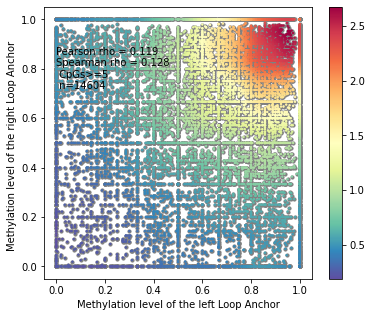

In [117]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

pdffile = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Methylation/loop_anchors_correlation_rep1_all_filterCpG%d.pdf"%filterNCpGs
sns.set_color_codes("muted")
plt.figure(figsize=(6,5))
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
plt.scatter(x,y, s=10, edgecolor=None, c = "grey")
plt.scatter(x, y,c=z,  s=2, edgecolor=None, cmap='Spectral_r')
plt.text(0,0.8, "Pearson rho = %.3f\nSpearman rho = %.3f\n CpGs>=%d \n n=%d"%(pr[0],sr[0], filterNCpGs, len(x)), 
         ha="left", va="center" )
plt.colorbar()
plt.xlabel("Methylation level of the left Loop Anchor")
plt.ylabel("Methylation level of the right Loop Anchor  ")
plt.savefig(pdffile)


U test p value: 5.6400152103706336e-39


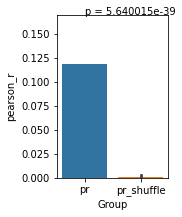

In [120]:
# Random shuffle x
import random
PearsonR_dict = {"pr":[],
                "pr_shuffle":[]}
for n in range(0, 100):
    shufflex = random.shuffle(x)
    shuffley = random.shuffle(y)
    pr_shuffle = stats.pearsonr( x, y)
    PearsonR_dict["pr"].append(pr[0])
    PearsonR_dict["pr_shuffle"].append(pr_shuffle[0])
PearsonR_df = pd.DataFrame(PearsonR_dict)
Utest = stats.mannwhitneyu(PearsonR_df.pr.values, PearsonR_df.pr_shuffle.values,alternative='two-sided')
u_p_value = Utest[1]
print("U test p value:", u_p_value )

pdffile = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Methylation/Reads_loop_anchors_correlation_shuffle_compare_filterCpG%d.pdf"%filterNCpGs
sns.set_color_codes("muted")
plt.figure(figsize=(2,3))
#plt.bar(PearsonR_df)
Stack_df = PearsonR_df.stack().reset_index()
Stack_df.columns = ["Index", "Group", "pearson_r"]
sns.barplot(data=Stack_df, x="Group", y="pearson_r")
plt.ylim([0,0.170])
plt.text(0, 0.17, "p = %e"%u_p_value)
plt.savefig(pdffile)